In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import recall_score, f1_score, precision_score, make_scorer
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
from scipy import interp
warnings.filterwarnings('ignore')

In [72]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [73]:
X = data.iloc[:,2:].values
y = data.iloc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y, random_state=1)

In [75]:
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Правильность при испытании: %.3f' % pipe_lr.score(X_test, y_test))

Правильность при испытании: 0.956


### Использование стратифицированной перекрестной проверки по k блокам для оценки эффективности модели

In [76]:
kfold = StratifiedKFold(n_splits=10, random_state=1).split(X_train,y_train)
# n_splits - количество блоков 
scores = []
for k, (train,test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Блок: %2d, Распределение классов: %s, правильность: %.3f' % (k+1,np.bincount(y_train[train]), score))

Блок:  1, Распределение классов: [256 153], правильность: 0.935
Блок:  2, Распределение классов: [256 153], правильность: 0.935
Блок:  3, Распределение классов: [256 153], правильность: 0.957
Блок:  4, Распределение классов: [256 153], правильность: 0.957
Блок:  5, Распределение классов: [256 153], правильность: 0.935
Блок:  6, Распределение классов: [257 153], правильность: 0.956
Блок:  7, Распределение классов: [257 153], правильность: 0.978
Блок:  8, Распределение классов: [257 153], правильность: 0.933
Блок:  9, Распределение классов: [257 153], правильность: 0.956
Блок: 10, Распределение классов: [257 153], правильность: 0.956


### Отладка алгоритмов с помощью кривых обучения и проверки

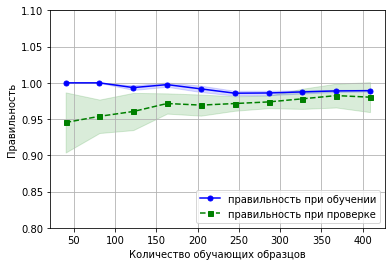

In [77]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=1))
# learning_curve - функция кривой обучения из sklearn
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,X=X_train,y=y_train, 
                                                        train_sizes=np.linspace(0.1,1.0,10),
                                                       cv=10, n_jobs=1)
# train_sizes - применяем 10 равноотстоящих интервалов для размеров обучающих наборов
# cv - количество блоков 
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1) # Стандартное отклонение
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o',markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green',linestyle='--', marker='s',markersize=5, label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Количество обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='lower right')
plt.ylim([0.8,1.1])
plt.show()

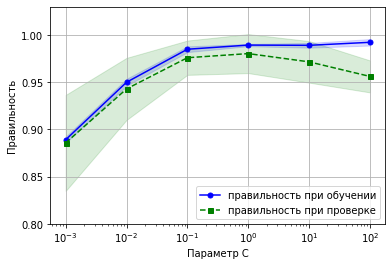

In [78]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] # перебираемые параметры
train_scores, test_scores = validation_curve(estimator=pipe_lr, X = X_train, y = y_train,
                                            param_name='logisticregression__C',
                                            param_range=param_range,
                                            cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1) # Стандартное отклонение
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o',markersize=5, label='правильность при обучении')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green',linestyle='--', marker='s',markersize=5, label='правильность при проверке')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Параметр С')
plt.ylabel('Правильность')
plt.legend(loc='lower right')
plt.ylim([0.8,1.03])
plt.show()

### Точная настройка моделей машинного обучения с помощью решетчатого поиска
Применим популярный прием решетчатый поиск, который может дополнительно содействовать повышению эффективности модели, отыскивая оптимальную комбинацию значений гиперпараметров

In [79]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] # перебираемые значения
param_grid = [{'svc__C':param_range, 'svc__kernel':['linear']},
              {'svc__C':param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,scoring='accuracy', cv=10,n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print()
print(gs.best_params_)

0.9846859903381642

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [80]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Правильность: %.3f' % clf.score(X_test, y_test))

Правильность: 0.974


### Использование матрицы неточностей (ошибок)
Матрица ошибок - квадратная матрица, описывающая численности истинно положительных (True Positive - TP), истинно отрицательных (True Negative - TN), ложноположительных (False Positive - FP), ложноотрицательных (False Negative - FN) прогнозов классификатора

In [81]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


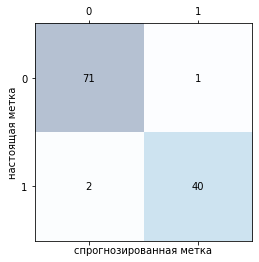

In [82]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j],
               va='center', ha='center')
plt.xlabel('спрогнозированная метка')
plt.ylabel('настоящая метка')
plt.show()
    

Из графика видно, что наша модель корректно классифицировала 71 образец (истинно отрицательные) и 40 образцов (истинно положительные). Тем не менее, модель так же неправильно классифицировала 2 образца из класса 1 как принадлежащие к классу 0, и спрогнозировала, что 1 образец относится к классу 1 из класса 0.  

In [83]:
print('Точность: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))

Точность: 0.976


In [84]:
print('Полнота: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))

Полнота: 0.952


In [85]:
print('Мера F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Мера F1: 0.964


In [86]:
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer,cv=10)
gs.fit(X_train, y_train)
print(gs.best_score_)
print()
print(gs.best_params_)

0.9880771478667446

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


### Построение кривой рабочей характеристики приемника
Кривая рабочей характеристики приемника(Receiver Operating Characteristic - ROC) - удобный инструмент для отбора классификационных моделей на основе их эффективности относительно FPR(False Positive Rate) и TPR(True Positive Rate), которые вычисляются путем сдвига поворота принятия решения у классификатора. 

Так же, основываясь на кривой ROC, можно вычислить так называемую площадь под кривой ROC (ROC Area Under the Curve - ROC AUC), для получения характеристики эффективности классификационной модели

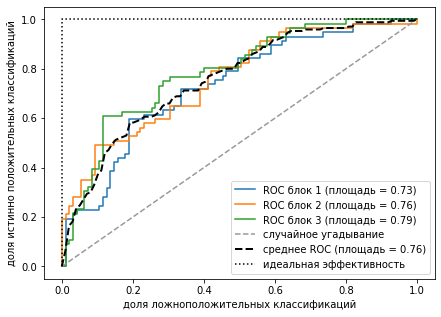

In [87]:
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(penalty='l2', random_state=1, C=100.0))
X_train_2 = X_train[:, [4,14]]
cv = list(StratifiedKFold(n_splits=3,random_state=1,).split(X_train, y_train))
fig = plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0,1,100)
all_tpr = []
for i,(train,test) in enumerate(cv):
    probas = pipe_lr.fit(X_train_2[train], y_train[train]).predict_proba(X_train_2[test])
    fpr, tpr, tresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr,tpr) # вычисление площади под кривой 
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label='ROC блок %d (площадь = %0.2f)' % (i + 1, roc_auc))
    
plt.plot([0,1],[0,1], linestyle='--', color=(0.6,0.6,0.6), label='случайное угадывание')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='среднее ROC (площадь = %0.2f)' % mean_auc, lw=2)
plt.plot([0,0,1],[0,1,1],linestyle=':',color='black',label='идеальная эффективность')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных классификаций')
plt.ylabel('доля истинно положительных классификаций')
plt.legend(loc='lower right')
plt.show()